# H1C IDR3.2 Inspect

In [3]:
import os
import h5py
import numpy as np

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import cptools as cp
from library import cpplots as plot
from library import dspec
from library import flagging
from library import clean

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# configure matplotlib
mpl.style.use("classic")

## Load Data
Load closure phases of equilateral 14.6 metre triads of field A. Meta data is printed below cell.

In [8]:
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FA_B2.h5"

with h5py.File(path, "r") as f:
    jd = f["JD"][()]
    lst = f["LST"][()]
    bispec = f["bispec"][()]
    trlist = f["triads"][()]

phase = np.angle(bispec)

# generate frequency array
frqrange = [152.25, 167.97]
fmin, fmax, fN = (100, 200, 1024)
df = (fmax - fmin) / fN
fs = fN / (fmax-fmin)
frq = np.arange(frqrange[0], frqrange[1], df)

# time data
jdmin, jdmax = np.min(jd), np.max(jd)
lstmin, lstmax, lstN = np.min(lst), np.max(lst), len(lst)
dt = (lstmax - lstmin) * 3600 / lstN

print(f"data has shape {bispec.shape}")
print(f"JD range {jdmin}-{jdmax}, {len(jd)} nights")
print(r"LST range {:.2f}-{:.2f} h, integration time {:.2f} s".format(lstmin, lstmax, dt))
print(r"frequency range {:.2f}-{:.2f} MHz, channel width {:.4f} MHz".format(fmin, fmax, df))

data has shape (2, 27, 55, 139, 161)
JD range 2458039-2458068, 27 nights
LST range 21.51-23.98 h, integration time 64.14 s
frequency range 100.00-200.00 MHz, channel width 0.0977 MHz


## Average Data Products

In [6]:
mphase1 = cp.circmed(phase, axis=1)
mphase2 = cp.circmed(phase, axis=2)

print(f"median phase 1 has shape {mphase1.shape}")
print(f"median phase 2 has shape {mphase2.shape}")

median phase 1 has shape (2, 55, 139, 161)
median phase 2 has shape (2, 27, 139, 161)


In [44]:
bispecRFI = np.nanmean(bispec, axis=(0, 2))

print(f"RFI data has shape {bispecRFI.shape}")

RFI data has shape (27, 139, 161)


## Plots

In [19]:
def plot(pol, j, tr, t):
    plt.plot(
        frq,
        phase[pol, j, tr, t] * 180 / np.pi,
        color="k",
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",
        label=f"Triad {tr}"
    )
    plt.plot(
        frq,
        mphase1[pol, tr, t] * 180 / np.pi,
        color="b",
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",
        label="Median over Days"
    )
    plt.plot(
        frq,
        mphase2[pol, j, t] * 180 / np.pi,
        color="orange",
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",
        label="Median over Triads"
    )

    plt.legend(numpoints=1, fontsize=20, bbox_to_anchor=(1.65, 1.02))
    plt.title("Polarisation {}, JD {}, Triad {}, LST {:.2f} h".format(pol, jd[j], tr, lst[t]), fontsize=20)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Closure Phase (deg)")
    plt.xlim(frqrange)
    plt.ylim([-180, 180])
    plt.minorticks_on()
    plt.show()


interact(plot, pol=(0, 1, 1), j=(0, len(jd)-1, 1), tr=(0, 54, 1), t=(0, len(lst)-1, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=13, description='j', max=2…

<function __main__.plot(pol, j, tr, t)>

In [33]:
def plot(pol, t):
    plt.plot(
        frq,
        np.swapaxes(mphase2[pol, :, t] * 180 / np.pi, 0, 1),
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",

    )

    plt.title("Polarisation {}, LST {:.2f} h, avg. over triads".format(pol, lst[t]), fontsize=20)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Closure Phase (deg)")
    plt.xlim(frqrange)
    plt.ylim([-180, 180])
    plt.minorticks_on()
    plt.show()


interact(plot, pol=(0, 1, 1), t=(0, len(lst)-1, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=69, description='t', max=1…

<function __main__.plot(pol, t)>

In [34]:
def plot(pol, t):
    plt.plot(
        frq,
        np.swapaxes(mphase1[pol, :, t] * 180 / np.pi, 0, 1),
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",
    )

    plt.title("Polarisation {}, LST {:.2f} h, avg. over JD".format(pol, lst[t]), fontsize=20)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Closure Phase (deg)")
    plt.xlim(frqrange)
    plt.ylim([-180, 180])
    plt.minorticks_on()
    plt.show()


interact(plot, pol=(0, 1, 1), t=(0, len(lst)-1, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=69, description='t', max=1…

<function __main__.plot(pol, t)>

In [41]:
def plot(pol, j, tr):
    im = plt.imshow(
        np.flip(phase[pol, j, tr], axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    plt.title(f"Polarisation {pol}, JD {jd[j]}, Triad {tr}")
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plot, pol=(0, 1, 1), j=(0, len(jd)-1, 1), tr=(0, 54, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=13, description='j', max=2…

<function __main__.plot(pol, j, tr)>

In [56]:
def plot(j):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    im1 = ax[0].imshow(
        np.flip(np.angle(bispecRFI[j]), axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )
    im2 = ax[1].imshow(
        np.flip(np.abs(bispecRFI[j]), axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.bone,
        interpolation="None",
        aspect="auto",
        vmin=0, 
        vmax=1e-3
    )
    
    ax[0].set_title(f"JD {jd[j]}, Bispectrum Phase")
    ax[1].set_title(f"JD {jd[j]}, Bispectrum Amplitude")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, len(jd)-1, 1))

interactive(children=(IntSlider(value=13, description='j', max=26), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(j)>

## Median over Triads

In [25]:
mphase = cp.circmed(np.angle(bispec_avg), axis=2)

print("median data has shape {}".format(mphase.shape))

median data has shape (2, 54, 139, 161)


## Metric 1: No-Signal
Some closure phase triads don't show any sky signal (white noise only). The purpose of this metric is to identify these triads on a per day and polarisation basis. The time it takes to compute the metric is of order ~10 minutes. The metric is calculated as

$z_{1,i} = \frac{2}{\pi} \mathrm{med} \{\phi_{i, t, \nu} - \mathrm{med} \{ \phi_{i, t, \nu} \}_{i} + \xi_{i, t, \nu}\}_{t, \nu}$,

where $i$, $t$ and $\nu$ are the triad number the time and the frequency respectively and $\xi \in \{-2 \pi, 0, 2 \pi \}$ account for the circularity of the phase. For a statistically random phase the value of the metric will be close to 1. The better the redundancy of a triad with respect to the other triads, the closer it's $z_1$ will be to zero.

In [26]:
phase = np.angle(bispec_avg)
shape = phase.shape
dphase = cp.phase_diff(np.moveaxis(phase, 2, 0), mphase)
z1 = np.nanmedian(np.abs(dphase), axis=(-2, -1)) * 2 / np.pi
z1 = np.moveaxis(z1, 0, -1) 

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


### plot metric
The metric values are clearly bimodal, allowing to easily identify triads formed from bad correlations.

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


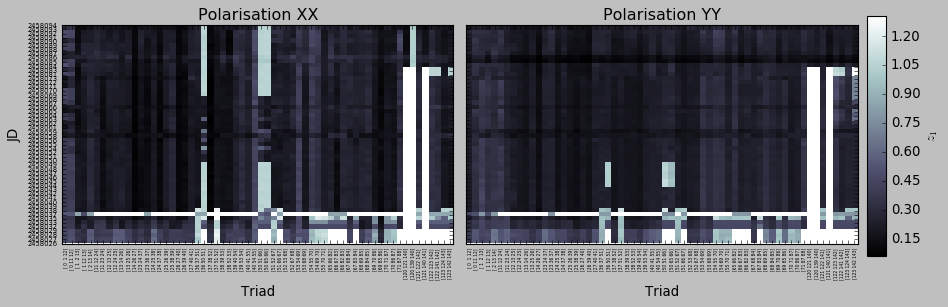

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
im1 = ax[0].imshow(z1[0], aspect="auto", interpolation="None", cmap=cm.bone)
im2 = ax[1].imshow(z1[1], aspect="auto", interpolation="None", cmap=cm.bone)

ax[0].set_ylabel("JD")
ax[0].set_yticklabels(jd, fontsize=6)
ax[0].set_xticklabels(trlist, fontsize=4, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=4, rotation=90)
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")

plt.setp(ax, 
         xlabel="Triad",
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(jd), 1.0))

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.18, 0.02, 0.75])
fig.colorbar(im2, cax=cbar_ax, label=r"$z_1$")


 ### plot bad data
 This is a clipped version of the plot above. Each polarisation, day and triad is assigned a value of 1 or 0 depending on whether it's metric value is above or below a certain threshold (0.7)

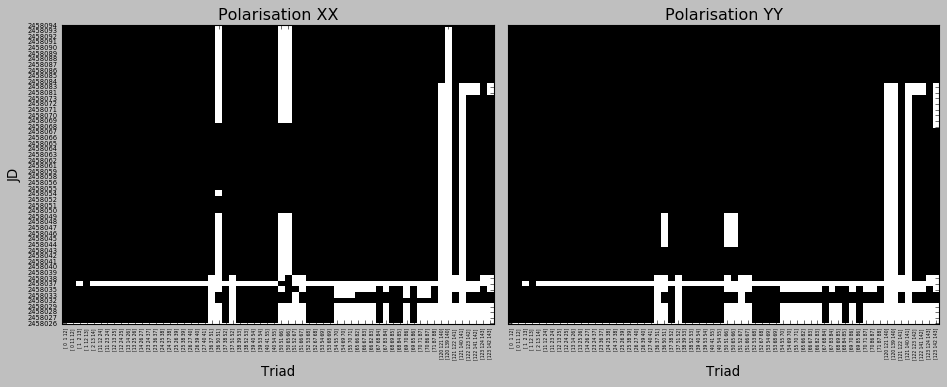

In [28]:
z1_clip = z1.copy()
z1_clip[np.where(z1 < 0.7)] = 0
z1_clip[np.where(z1 > 0.7)] = 1

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
im1 = ax[0].imshow(z1_clip[0], aspect="auto", interpolation="None", cmap=cm.bone)
im2 = ax[1].imshow(z1_clip[1], aspect="auto", interpolation="None", cmap=cm.bone)

ax[0].set_ylabel("JD")
ax[0].set_yticklabels(jd, fontsize=6)
ax[0].set_xticklabels(trlist, fontsize=4, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=4, rotation=90)
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")

plt.setp(ax, 
         xlabel="Triad",
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(jd), 1.0))

plt.tight_layout()

### Combine Polarisations
The metric is only 0 (black) if the metric-values of both polarisations are 0.

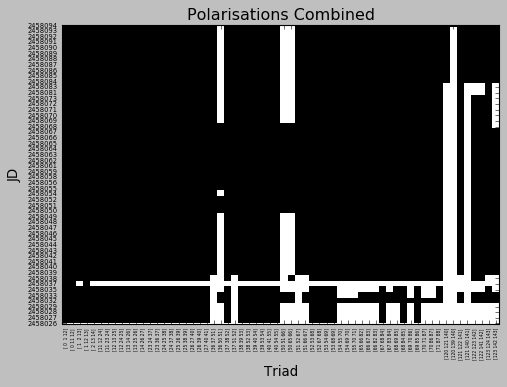

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5), sharey=True)
im = ax.imshow(np.max(z1_clip, axis=0), aspect="auto", interpolation="None", cmap=cm.bone)

ax.set_yticklabels(jd, fontsize=6)
ax.set_xticklabels(trlist, fontsize=4, rotation=90)

plt.setp(ax,
         title="Polarisations Combined",
         xlabel="Triad",
         ylabel="JD",
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(jd), 1.0))

plt.tight_layout()

### Memo Plot

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


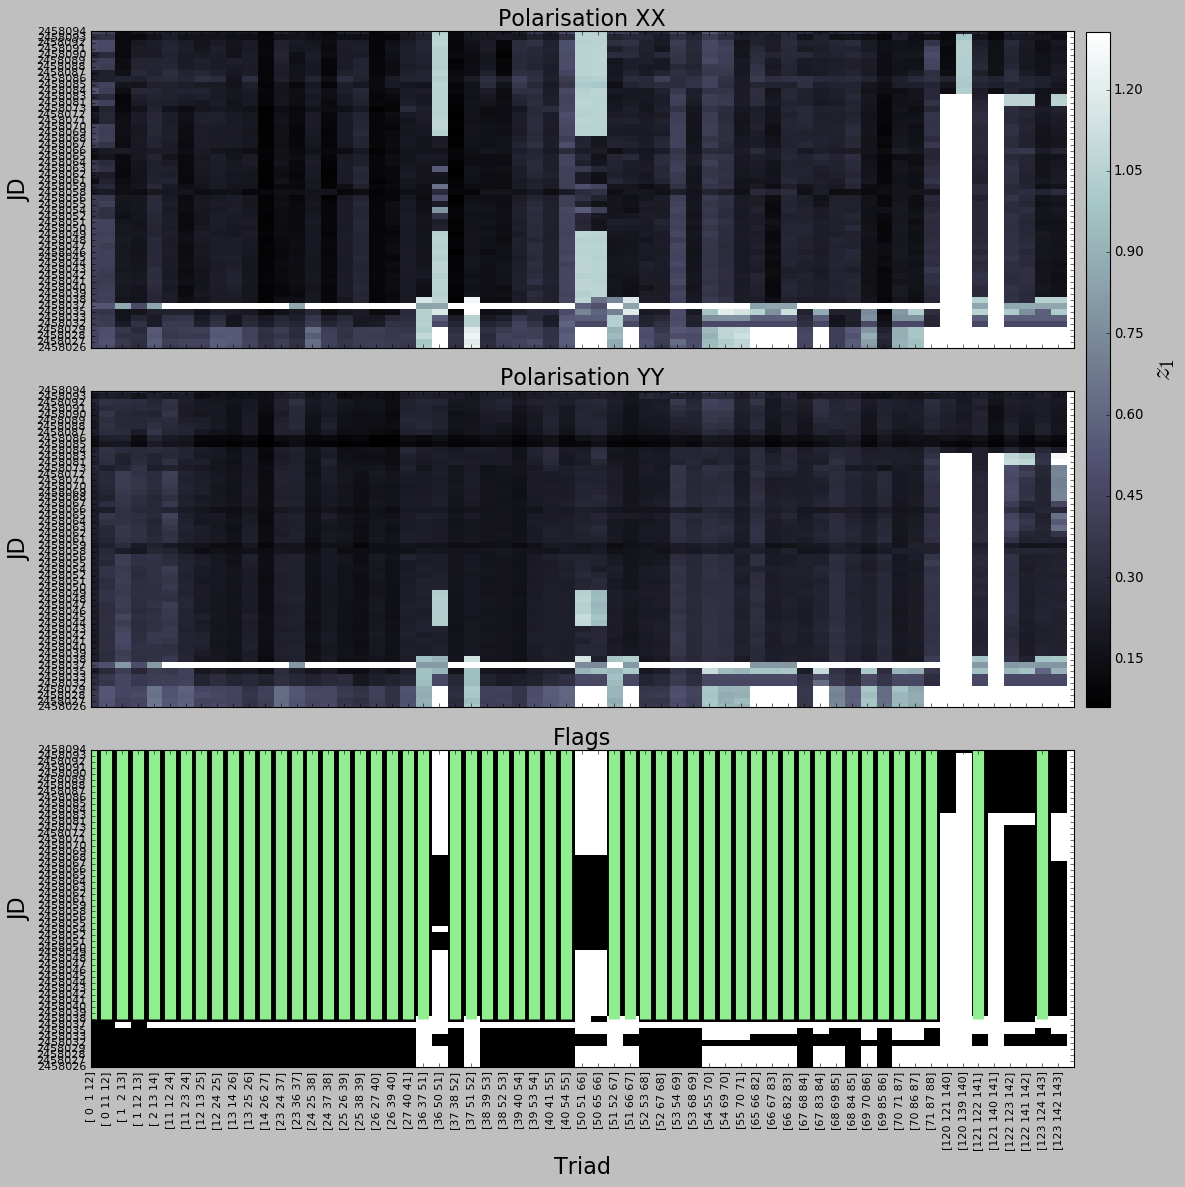

In [30]:
idx = np.where(jd > 2458038)[0]
jdf = jd[idx]
z1_collapse = np.max(z1_clip[:, idx], axis=(0, 1))
goodtr = np.where(z1_collapse == 0)[0]

fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
im1 = ax[0].imshow(z1[0], aspect="auto", interpolation="None", cmap=cm.bone)
im2 = ax[1].imshow(z1[1], aspect="auto", interpolation="None", cmap=cm.bone)
im3 = ax[2].imshow(np.max(z1_clip, axis=0), aspect="auto", interpolation="None", cmap=cm.bone)

ax[0].set_yticklabels(jd, fontsize=10)
ax[1].set_yticklabels(jd, fontsize=10)
ax[2].set_yticklabels(jd, fontsize=10)
ax[2].set_xticklabels(trlist, fontsize=10, rotation=90)
ax[0].set_title("Polarisation XX", fontsize=20)
ax[1].set_title("Polarisation YY", fontsize=20)
ax[2].set_title("Flags", fontsize=20)
ax[2].set_xlabel("Triad", fontsize=20)
ax[0].set_ylabel("JD", fontsize=20)
ax[1].set_ylabel("JD", fontsize=20)
ax[2].set_ylabel("JD", fontsize=20)
ax[2].vlines(goodtr, 0, 45, color="lightgreen", linewidth=10)

plt.setp(ax, 
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(jd), 1.0),
         xlim=[0, 62])

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.405, 0.02, 0.563])
fig.colorbar(im2, cax=cbar_ax).set_label(label=r"$z_1$", size=25)

plt.savefig("/users/pkeller/plots/memo_plot_1.pdf")

### select a subset of the data
Select only triads that are good in both polarisations and among all observing nighs between JD 2458039 and JD 248094.

In [31]:
idx = np.where((jd > 2458038) & (jd < 2458069))[0]
jdf = jd[idx]
z1_collapse = np.max(z1_clip[:, idx], axis=(0, 1))
goodtr = np.where(z1_collapse == 0)[0]
phasef = phase[:, idx][:, :, goodtr]
print(f"flagged data has shape {phasef.shape}")

flagged data has shape (2, 27, 55, 139, 161)


### write to file

In [42]:
f = h5py.File("/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FA_B2.h5", "w")
f.create_dataset("JD", data=jdf)
f.create_dataset("LST", data=lst_avg)
f.create_dataset("bispec", data=bispec_avg[:, idx][:, :, goodtr])
f.create_dataset("triads", data=trlist)
f.close()

### median over observing nights

In [32]:
mphasef = cp.circmed(phasef, axis=1)

### plot phase

In [38]:
def plotPh(pol, j, tr, t):
    plt.plot(
        frq,
        phasef[pol, j, tr, t] * 180 / np.pi,
        color="b",
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",
        label=f"Triad {tr}"
    )
    plt.plot(
        frq,
        mphasef[pol, tr, t] * 180 / np.pi,
        color="k",
        linewidth=0.0,
        markersize=5,
        marker="o",
        markeredgecolor="None",
        label="Median over Days"
    )

    plt.legend(numpoints=1, fontsize=20)
    plt.title("Polarisation {}, Triad {}, LST {:.2f} h".format(pol, tr, lst_avg[t]), fontsize=20)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Closure Phase (deg)")
    plt.xlim(frqrange)
    plt.ylim([-180, 180])
    plt.minorticks_on()
    plt.show()


interact(plotPh, pol=(0, 1, 1), j=(0, 20, 1), tr=(0, 52, 1), t=(0, 138, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=10, description='j', max=2…

<function __main__.plotPh(pol, j, tr, t)>

In [39]:
def plotPh(pol, jd, tr):
    im = plt.imshow(
        np.flip(phasef[pol, jd, tr], axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    #plt.xticks(np.arange(min(frq), max(frq)+1, 5.0))
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plotPh, pol=(0, 1, 1), jd=(0, 44, 1), tr=(0, 52, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=22, description='jd', max=…

<function __main__.plotPh(pol, jd, tr)>

In [35]:
RFI = np.nanmean(bispec[:, idx][:, :, goodtr], axis=(0, 2))

In [36]:
def plotPh(j):
    print(jd[j])
    plt.imshow(
        np.flip(np.angle(RFI[j]), axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.plasma,
        interpolation="None",
        aspect="auto",
        vmin=0,
        vmax=1,
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    #plt.xticks(np.arange(min(frq), max(frq)+1, 5.0))
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plotPh, j=(0, 27, 1))

interactive(children=(IntSlider(value=13, description='j', max=27), Output()), _dom_classes=('widget-interact'…

<function __main__.plotPh(j)>

In [37]:
def plotPh(pol, jd, tr):
    im = plt.imshow(
        np.flip(phaseF[pol, jd, tr], axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    #plt.xticks(np.arange(min(frq), max(frq)+1, 5.0))
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plotPh, pol=(0, 1, 1), jd=(0, 20, 1), tr=(0, 52, 1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=10, description='jd', max=…

<function __main__.plotPh(pol, jd, tr)>

## RFI Metric
Identify RFI on a per day, time and frequency basis. First define the phase difference with respect to the median among different oberserving nights.

$\Delta \phi_{i, p, d, t, \nu} = |\phi_{i, p, d, t, \nu} - \mathrm{med} \{ \phi_{i, p, d, t, \nu} \}_d|$,

where $i, p, d, t$ and $\nu$ are the triad, polarisation, day, time and frequency indices respectively. The median absolute deviation is then

$\sigma^\mathrm{MAD}_{i, p, t, \nu} = \mathrm{med} \{ \Delta \phi_{i, p, d, t, \nu} \}_d$

and the metric for flagging RFI is defined as

$z_\mathrm{RFI}(d, t, \nu) = \mathrm{med}\left( \frac{\Delta \phi_{i, p, d, t, \nu}}{\sigma^\mathrm{MAD}_{i, p, t, \nu}} \right)_{p, i}$.

## Metric for flagging bad days
The purpos of this metric is to identify days that have bad data, e.g., because the system was malfunctioning or because of severe RFI. This metric is derived from Metric 4

$z(d) = \left< z_\mathrm{RFI}(d, t, \nu) \right>_{t, \nu}$

In [180]:
dphasef = cp.phase_diff(np.moveaxis(phasef, 0, 1), mphasef)
mad = np.nanmedian(dphasef, axis=0)
z4 = np.nanmedian((dphasef / mad), axis=(1, 2))
z5 = np.mean(z4**2, axis=(1, 2))

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


### plot metric (bad days)
There seem to be only three days that stand out (z > 2). These are 2459131, 2459117 and 2459115.

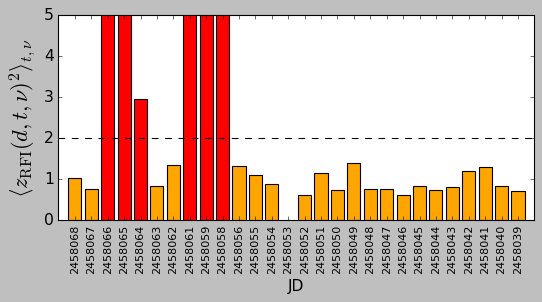

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharey=True)
colours = np.array(len(jdf) * ["orange"])
colours[np.where(z5 >= 2)[0]] = "r"
ax.bar(np.arange(len(jdf)), z5, color=colours)
ax.set_xticklabels(jdf, fontsize=10, rotation=90)
ax.hlines(2, -1, 60, linestyle="dashed")
ax.set_ylabel(r"$\left< z_\mathrm{RFI}(d, t, \nu)^2 \right>_{t, \nu}$", fontsize=20)
plt.setp(ax, xlabel="JD", xticks=np.arange(len(jdf)), xlim=[-1, len(jdf)], ylim=[0, 5])
plt.tight_layout()
plt.savefig("/users/pkeller/plots/memo_plot_2.pdf")

In [182]:
def mkplot(jdi):
    print(jdf[jdi])
    plot.rfiz(lst, frq, z4[jdi]**2, vmax=5)
    plt.show()
    
interact(mkplot, jdi=(0, len(jdf)-1))

interactive(children=(IntSlider(value=13, description='jdi', max=27), Output()), _dom_classes=('widget-interac…

<function __main__.mkplot(jdi)>

In [127]:
rfi = np.zeros_like(z4)
rfi[np.where((z4**2>=3) | (z4**2<=0.2) | np.isnan(z4))] = 1
def mkplot(jdi):
    print(jdf[jdi])
    plot.rfiz(lst, frq, rfi[jdi], vmax=1)
    plt.show()

interact(mkplot, jdi=(0, len(jdf)-1))

interactive(children=(IntSlider(value=13, description='jdi', max=27), Output()), _dom_classes=('widget-interac…

<function __main__.mkplot(jdi)>

## Metric 2: Noisy Triads

Identify triads that have an excess of noise. First define the phase difference with respect to the median among different oberserving nights.

$\Delta \phi_{i, p, d, t, \nu} = |\phi_{i, p, d, t, \nu} - \mathrm{med} \{ \phi_{i, p, d, t, \nu} \}_d + \xi_{i, t, \nu}|$,

where $i, p, d, t$ and $\nu$ are the triad, polarisation, day, time and frequency indices respectively. The median absolute deviation is then

$\sigma^\mathrm{MAD}_{i, p, t, \nu} = \mathrm{med} \{ \Delta \phi_{i, p, d, t, \nu} \}_d$.

Metric 2 is defined as

$z_2 = \mathrm{med} \left( \frac{ \sigma^\mathrm{MAD}_{i, p, t, \nu}}{\mathrm{med} \{ \sigma^\mathrm{MAD}_{i, p, t, \nu} \}_i} \right)_{t, \nu}$

In [60]:
phaseF = phasef[:, np.where(z5 < 2)[0]]
mphaseF = cp.circmed(phaseF, axis=1)

In [61]:
dphaseF = cp.phase_diff(np.moveaxis(phaseF, 0, 1), mphaseF)
mad = np.moveaxis(np.nanmedian(np.abs(dphaseF), axis=0), 1, 0)
z2 = np.nanmedian(mad / np.nanmedian(mad, axis=0), axis=(2, 3))

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


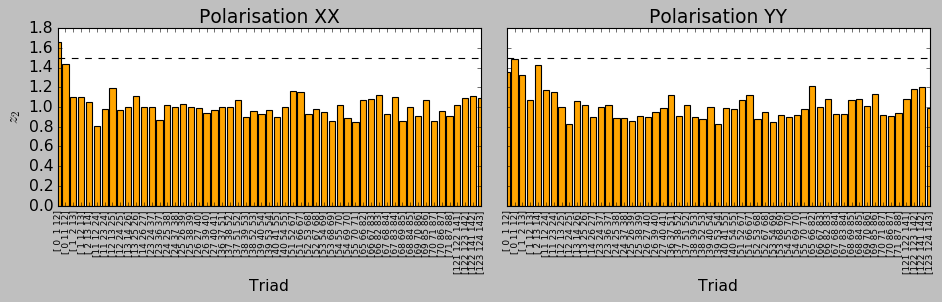

In [62]:
shape = phaseF.shape
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].bar(np.arange(shape[2]), z2[:, 0], color="orange")
ax[1].bar(np.arange(shape[2]), z2[:, 1], color="orange")
ax[0].hlines(1.5, 0, 60, linestyle="dashed")
ax[1].hlines(1.5, 0, 60, linestyle="dashed")
ax[0].set_ylabel(r"$z_2$")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
ax[0].set_xticklabels(trlist[goodtr], fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist[goodtr], fontsize=8, rotation=90)

plt.setp(ax, xlabel="Triad", xlim=[0, len(goodtr)-1], xticks=np.arange(0, len(goodtr), 1.0),)
plt.tight_layout()

## Metric 3: Redundancy
Identify triads that have a poor redundancy with respect to other triads in the array. First define the phase difference with respect to the median among different oberserving nights and triads.

$\Delta \phi_{i, p, d, t, \nu} = |\phi_{i, p, d, t, \nu} - \mathrm{med} \{ \phi_{i, p, d, t, \nu} \}_{d, i} + \xi_{i, t, \nu}|$,

where $i, p, d, t$ and $\nu$ are the triad, polarisation, day, time and frequency indices respectively. The median absolute deviation is then

$\sigma^\mathrm{MAD}_{i, p, t, \nu} = \mathrm{med} \{ \Delta \phi_{i, p, d, t, \nu} \}_d$.

Metric 3 is defined similarly to metric 3

$\mathrm{med} \left( \frac{\sigma^\mathrm{MAD}_{i, p, t, \nu}}{\mathrm{med} \{ \sigma^\mathrm{MAD}_{i, p, t, \nu} \}_i} \right)_{t, \nu}$

In [63]:
mphasef3 = cp.circmed(mphaseF, axis=1)
dphasef3 = cp.phase_diff(np.moveaxis(phasef, 0, 2), mphasef3)
var3 = np.nanmedian(np.abs(dphasef3), axis=0)
z3 = np.nanmedian(var3 / np.nanmedian(var3, axis=0), axis=(2, 3))

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


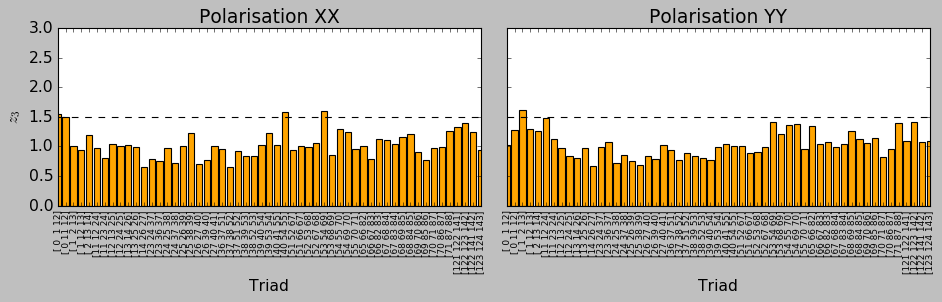

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].bar(np.arange(shape[2]), z3[:, 0], color="orange")
ax[1].bar(np.arange(shape[2]), z3[:, 1], color="orange")
ax[0].hlines(1.5, 0, 60, linestyle="dashed")
ax[1].hlines(1.5, 0, 60, linestyle="dashed")
ax[0].set_ylabel(r"$z_3$")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
ax[0].set_xticklabels(trlist[goodtr], fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist[goodtr], fontsize=8, rotation=90)

plt.setp(ax, xlabel="Triad", xlim=[0, len(goodtr)-1], ylim=[0, 3], xticks=np.arange(0, len(goodtr), 1.0),)
plt.tight_layout()

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


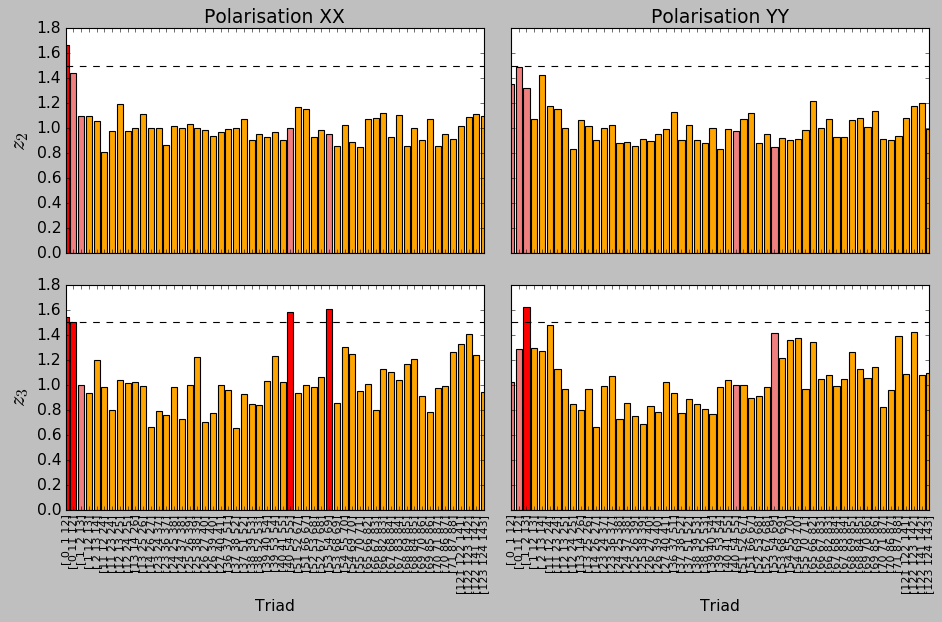

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)

colours[np.where((z2 >= 1.5) | (z3 >= 1.5))[0]] = "lightcoral"
colours[np.where(z2[:, 0] >= 1.5)[0]] = "red"
ax[0, 0].bar(np.arange(shape[2]), z2[:, 0], color=colours)

colours[np.where((z2 >= 1.5) | (z3 >= 1.5))[0]] = "lightcoral"
colours[np.where(z2[:, 1] >= 1.5)[0]] = "red"
ax[0, 1].bar(np.arange(shape[2]), z2[:, 1], color=colours)

colours[np.where((z2 >= 1.5) | (z3 >= 1.5))[0]] = "lightcoral"
colours[np.where(z3[:, 0] >= 1.5)[0]] = "red"
ax[1, 0].bar(np.arange(shape[2]), z3[:, 0], color=colours)

colours[np.where((z2 >= 1.5) | (z3 >= 1.5))[0]] = "lightcoral"
colours[np.where(z3[:, 1] >= 1.5)[0]] = "red"
ax[1, 1].bar(np.arange(shape[2]), z3[:, 1], color=colours)

ax[0, 0].hlines(1.5, 0, 60, linestyle="dashed")
ax[0, 1].hlines(1.5, 0, 60, linestyle="dashed")
ax[1, 0].hlines(1.5, 0, 60, linestyle="dashed")
ax[1, 1].hlines(1.5, 0, 60, linestyle="dashed")
ax[0, 0].set_title("Polarisation XX")
ax[0, 1].set_title("Polarisation YY")
ax[1, 0].set_xticklabels(trlist[goodtr], fontsize=10, rotation=90)
ax[1, 1].set_xticklabels(trlist[goodtr], fontsize=10, rotation=90)
ax[0, 0].set_ylabel(r"$z_2$", fontsize=20)
ax[1, 0].set_ylabel(r"$z_3$", fontsize=20)

plt.setp(ax[1], xlabel="Triad", xlim=[0, len(goodtr)-1], xticks=np.arange(0, len(goodtr), 1.0),)

plt.tight_layout()
plt.savefig("/users/pkeller/plots/memo_plot_5.pdf")

## JD Averaging
Average data using a circular median along JD-axis to reduce noise and data volume.

In [66]:
phase0 = cp.circmed(phaseF, axis=1)
print(f"data has shape {phase0.shape}")

data has shape (2, 55, 139, 161)


## Compute Delay Power Spectra

In [67]:
# window functions
eicp = np.exp(1j * phase0)
W = dspec.blackman_harris(eicp.shape[-1])
fs = fN / (fmax-fmin)

# compute delay power spectra
ps = dspec.xpspec(eicp, eicp, fs=fs, W=W, shift=True, inverse=True)
delay = dspec.delay(fs=fs, n=ps.shape[-1])

# median along LST
psm = np.nanmedian(ps, axis=2)
psmax = np.max(psm)

print(f"delay power spectrum data has shape {ps.shape}")

delay power spectrum data has shape (2, 55, 139, 161)


## Compute Noise Floor

In [68]:
eicp_diff = (np.exp(1j * phaseF[:, 2::2]) - np.exp(1j * phaseF[:, 1::2])) / np.sqrt(2)
psmax = np.max(ps)
c = eicp.shape[-1] / fs**2 / (27 * (2 / np.pi)) / psmax 
noise_floor = np.nanmean(np.abs(eicp_diff)**2, axis=-1) * c
noise_floor_uncertainty = np.std(noise_floor, axis=(1, 3)) / (noise_floor.shape[1] * noise_floor.shape[2])
noise_floor = np.nanmedian(noise_floor, axis=(1, 3))

## Plot Power Spectra

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:1342: ComplexWarning: Casting complex values to real discards the imaginary part
  seg = np.asarray(seg, float)


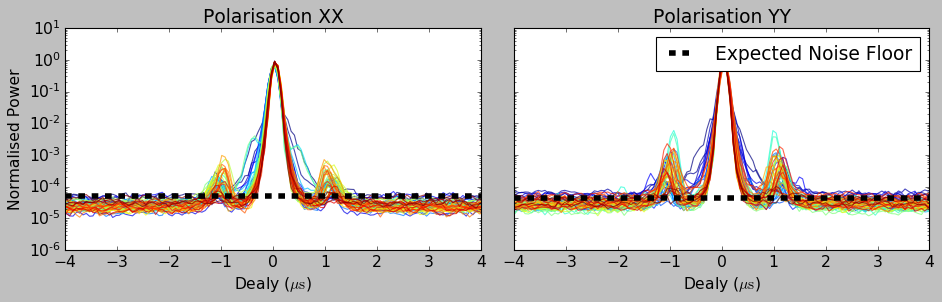

In [69]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

cm_subsection = np.linspace(0, 1, len(trlist[goodtr]))
colors = [cm.jet(x) for x in cm_subsection]

for i, c in enumerate(colors):
    ax[0].plot(delay, psm[0, i] / psmax, color=c, alpha=0.7)
    ax[1].plot(delay, psm[1, i] / psmax, color=c, alpha=0.7)

ax[0].hlines(np.median(noise_floor[0]), -4, 4, linestyle="dashed", linewidth=5, zorder=100)
ax[1].hlines(np.median(noise_floor[1]), -4, 4, linestyle="dashed", linewidth=5, zorder=100, label="Expected Noise Floor")
ax[0].set_ylabel("Normalised Power")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
plt.legend()    
plt.setp(ax, yscale="log", xlim=[-4, 4], ylim=[1e-6, 1e1], xlabel=r"Dealy ($\mu\mathrm{s}$)");
plt.tight_layout()
plt.savefig("/users/pkeller/plots/memo_plot_6.pdf")

## Metric: Spectral Structure
As can be seen in the plots above, some triads have quire a lot of spectral structure, expecially at delays of about 3 microseconds. The purpose of this metric is to easily identify the triads with the most spectral structure. If $\widetilde{\mathcal{E}}_i(p, \tau)$ is the fourier transform of the complex exponential of the closure phase of the $i^\mathrm{th}$ triad and polarisation $p$ at delay $\tau$, the metric is defined as

$z_{i, p} = \frac{\sigma_{i, p}}{\mathrm{med} \{ \sigma_{i, p} \}_i}$

where

$\sigma_{i, p} = \left< |\log{\widetilde{\mathcal{E}}_i(p, \tau)} - \mathrm{med} \left( \log{\widetilde{\mathcal{E}}_i(p, \tau)} \right)_d| \right>_\tau$.

In [88]:
print(logps.shape)

(55, 139, 2, 99)


In [82]:
idx = np.where((np.abs(delay) > 2))[0]
logps = np.moveaxis(np.log(ps[..., idx]), (1, 2), (0, 1))
var = np.median(np.abs(logps - np.median(logps, axis=(0, 1))), axis=(1, 3))
z4 = var / np.median(var, axis=0)
z4 = np.swapaxes(z4, 0, 1)

### Plot Metric

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


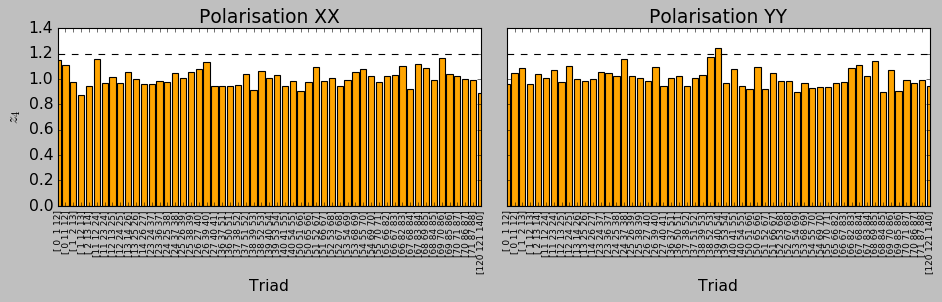

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].bar(np.arange(len(goodtr)), z4[0], color="orange")
ax[1].bar(np.arange(len(goodtr)), z4[1], color="orange")
ax[0].hlines(1.2, 0, 60, linestyle="dashed")
ax[1].hlines(1.2, 0, 60, linestyle="dashed")
ax[0].set_ylabel(r"$z_4$")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
ax[0].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=8, rotation=90)

plt.setp(ax, xlabel="Triad", xlim=[0, len(goodtr)-1], xticks=np.arange(0, len(goodtr), 1.0))
plt.tight_layout()

In [86]:
idx = np.where((np.abs(delay) > 2))[0]
noise = np.median(psm[..., idx] / psmax, axis=-1)
noise_uncertainty = np.std(psm[..., idx] / psmax, axis=-1) / np.sqrt(noise.shape[-1])

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


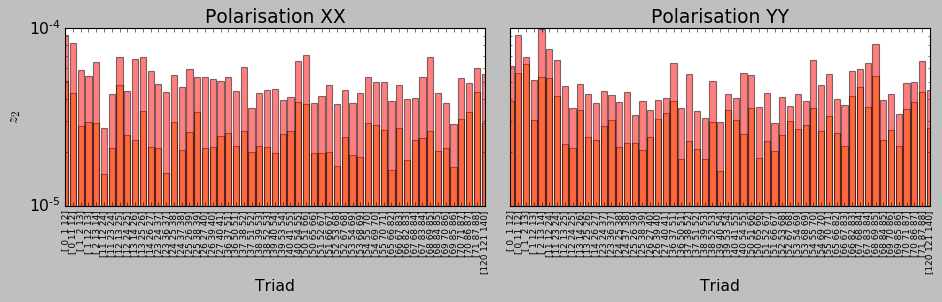

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].bar(np.arange(len(goodtr)), noise[0], color="orange", alpha=0.5)
ax[1].bar(np.arange(len(goodtr)), noise[1], color="orange", alpha=0.5)
ax[0].bar(np.arange(len(goodtr)), noise_floor[0], color="red", alpha=0.5)
ax[1].bar(np.arange(len(goodtr)), noise_floor[1], color="red", alpha=0.5)
ax[0].set_ylabel(r"$z_2$")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
ax[0].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=8, rotation=90)

plt.setp(ax, xlabel="Triad", xlim=[0, len(goodtr)-1], xticks=np.arange(0, len(goodtr), 1.0), yscale="log")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(12, 12), sharex=True, sharey="row")

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 0] >= 1.5) | (z3[:, 0] >= 1.5) | (z4[0] >= 1.5))[0]] = "lightcoral"
colours[np.where(z2[:, 0] >= 1.5)[0]] = "red"
ax[0, 0].bar(np.arange(shape[2]), z2[:, 0], color=colours)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 1] >= 1.5) | (z3[:, 1] >= 1.5) | (z4[1] >= 1.5))[0]] = "lightcoral"
colours[np.where(z2[:, 1] >= 1.5)[0]] = "red"
ax[0, 1].bar(np.arange(shape[2]), z2[:, 1], color=colours)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 0] >= 1.5) | (z3[:, 0] >= 1.5) | (z4[0] >= 1.5))[0]] = "lightcoral"
colours[np.where(z3[:, 0] >= 1.5)[0]] = "red"
ax[1, 0].bar(np.arange(shape[2]), z3[:, 0], color=colours)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 1] >= 1.5) | (z3[:, 1] >= 1.5) | (z4[1] >= 1.5))[0]] = "lightcoral"
colours[np.where(z3[:, 1] >= 1.5)[0]] = "red"
ax[1, 1].bar(np.arange(shape[2]), z3[:, 1], color=colours)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 0] >= 1.5) | (z3[:, 0] >= 1.5) | (z4[0] >= 1.5))[0]] = "lightcoral"
colours[np.where(z4[0] >= 1.5)[0]] = "red"
ax[2, 0].bar(np.arange(shape[2]), z4[0], color=colours)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 1] >= 1.5) | (z3[:, 1] >= 1.5) | (z4[1] >= 1.5))[0]] = "lightcoral"
colours[np.where(z4[1] >= 1.5)[0]] = "red"
ax[2, 1].bar(np.arange(shape[2]), z4[1], color=colours)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 0] >= 1.5) | (z3[:, 0] >= 1.5) | (z4[0] >= 1.5))[0]] = "lightcoral"
ax[3, 0].bar(np.arange(len(trlist)), noise[0], color=colours, alpha=1)

colours = np.array(z2.shape[0] * ["orange"]).astype(object)
colours[np.where((z2[:, 1] >= 1.5) | (z3[:, 1] >= 1.5) | (z4[1] >= 1.5))[0]] = "lightcoral"
ax[3, 1].bar(np.arange(len(trlist)), noise[1], color=colours, alpha=1)

ax[3, 0].bar(np.arange(len(trlist)), noise_floor[0], color="gray", alpha=0.5)
ax[3, 1].bar(np.arange(len(trlist)), noise_floor[1], color="gray", alpha=0.5, label="Expected NF")
ax[3, 1].legend()

ax[0, 0].hlines(1.5, 0, 41, linestyle="dashed")
ax[0, 1].hlines(1.5, 0, 41, linestyle="dashed")
ax[1, 0].hlines(1.5, 0, 41, linestyle="dashed")
ax[1, 1].hlines(1.5, 0, 41, linestyle="dashed")
ax[2, 0].hlines(1.5, 0, 41, linestyle="dashed")
ax[2, 1].hlines(1.5, 0, 41, linestyle="dashed")
ax[0, 0].set_title("Polarisation XX")
ax[0, 1].set_title("Polarisation YY")
ax[-1, 0].set_xticklabels(trlist, fontsize=10, rotation=90)
ax[-1, 1].set_xticklabels(trlist, fontsize=10, rotation=90)
ax[0, 0].set_ylabel(r"$z_2$", fontsize=20)
ax[1, 0].set_ylabel(r"$z_3$", fontsize=20)
ax[2, 0].set_ylabel(r"$z_4$", fontsize=20)
ax[3, 0].set_ylabel(r"Noise Floor")

plt.setp(ax[-1], xlabel="Triad", xlim=[0, len(goodtr)-1], xticks=np.arange(0, len(goodtr), 1.0), yscale="log")
plt.setp(ax[:-1], ylim=[0, 3])

plt.tight_layout()
plt.savefig("/users/pkeller/plots/memo_plot_5.pdf")

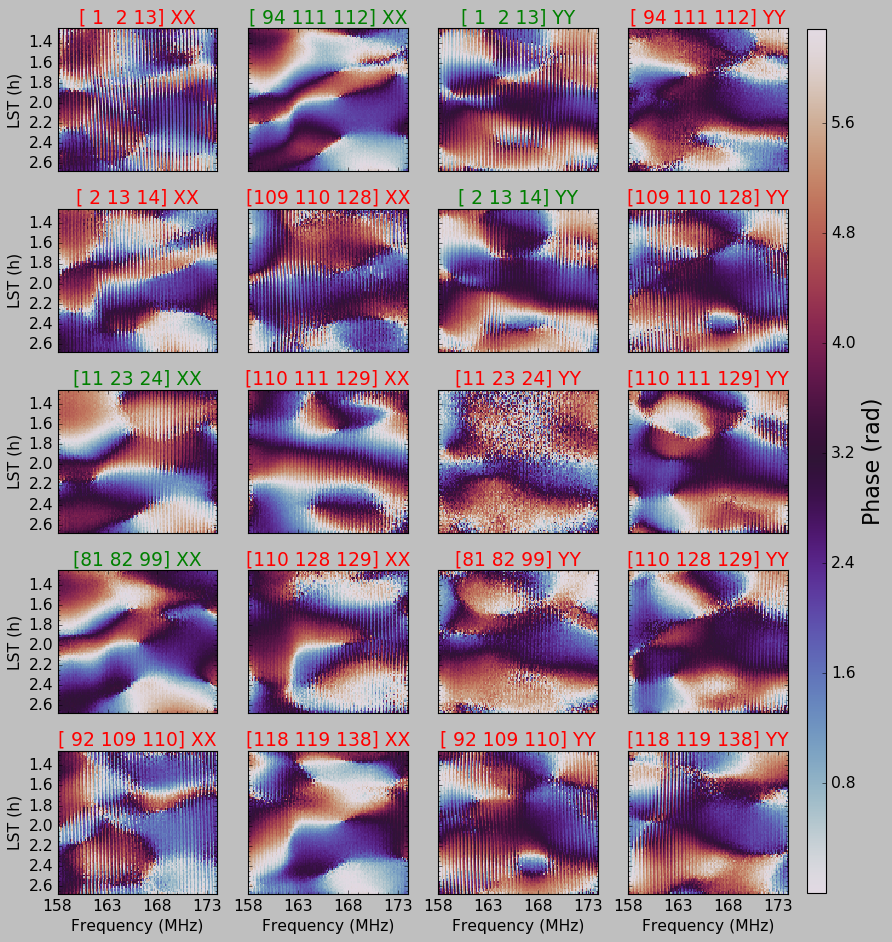

In [42]:
badtr = np.unique(np.where((z2 >= 1.5) | (z3 >= 1.5) | (np.swapaxes(z4, 0, 1) >= 1.5))[0]).reshape((2, 5))
badtr1 = np.where((z2[:, 0] >= 1.5) | (z3[:, 0] >= 1.5) | (np.swapaxes(z4, 0, 1)[:, 0] >= 1.5))[0]
badtr2 = np.where((z2[:, 1] >= 1.5) | (z3[:, 1] >= 1.5) | (np.swapaxes(z4, 0, 1)[:, 1] >= 1.5))[0]

fig, ax = plt.subplots(5, 4, figsize=(12, 12), sharex=True, sharey=True)

for i in range(badtr.shape[1]):
    for j in range(badtr.shape[0]):
        im = ax[i, j].imshow(
            np.flip(phase0[0, 0, badtr[j, i]], axis=0),
            extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
            cmap=cm.twilight,
            interpolation="None",
            aspect="auto",
        )
        
        if badtr[j, i] in badtr1:
            color = "red"
        else:
            color = "green"
            
        ax[i, j].set_title(str(trlist[badtr][j, i]) + " XX", color=color)
        
        im = ax[i, j+2].imshow(
            np.flip(phase0[1, 0, badtr[j, i]], axis=0),
            extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
            cmap=cm.twilight,
            interpolation="None",
            aspect="auto",
        )
        
        if badtr[j, i] in badtr2:
            color = "red"
        else:
            color = "green"

        ax[i, j+2].set_title(str(trlist[badtr][j, i]) + " YY", color=color)


plt.rc("font", size=14)
plt.setp(ax[-1], xlabel="Frequency (MHz)")
plt.setp(ax[:, 0], ylabel="LST (h)", ylim=[np.max(lst), np.min(lst)])
plt.xticks(np.arange(min(frq), max(frq)+1, 5.0))
plt.minorticks_on()
plt.tight_layout()

fig.subplots_adjust(right=0.83)
cbar_ax1 = fig.add_axes([0.85, 0.06, 0.02, 0.9])
fig.colorbar(im11, cax=cbar_ax1).set_label(label="Phase (rad)", size=20)
plt.savefig("/users/pkeller/plots/memo_plot_7.pdf")

In [43]:
goodtr = np.where((z2 < 1.5) & (z3 < 1.5) & (np.swapaxes(z4, 0, 1) < 1.5))[0]

_, phase1 = cp.lst_binning(phase[:, :, goodtr], lst, nlst=6, njd=2)
_, phase2 = cp.lst_binning(phase[:, :, goodtr], lst, nlst=6, njd=4)

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
xps, err = cp.xps_matrix(phase1, phase2, (max(frq)-min(frq))*1e6/2, fs*1e-6)
print(xps.shape, err.shape)

(2, 63, 63, 89, 65) (3, 2, 63, 63, 89, 65)


In [45]:
from library import rwtools as rw
model_path = "/lustre/aoc/projects/hera/pkeller/data/model/model_EQ14_2h_166MHz"
header, data = rw.readh5([], ["Scaling"], model_path)
A = data[0]

In [46]:
for i in range(xps.shape[-2]):
    xps[:, :, :, i] = A[i] * xps[:, :, :, i]
    err[:, :, :, :, i] = A[i] * err[:, :, :, :, i]

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


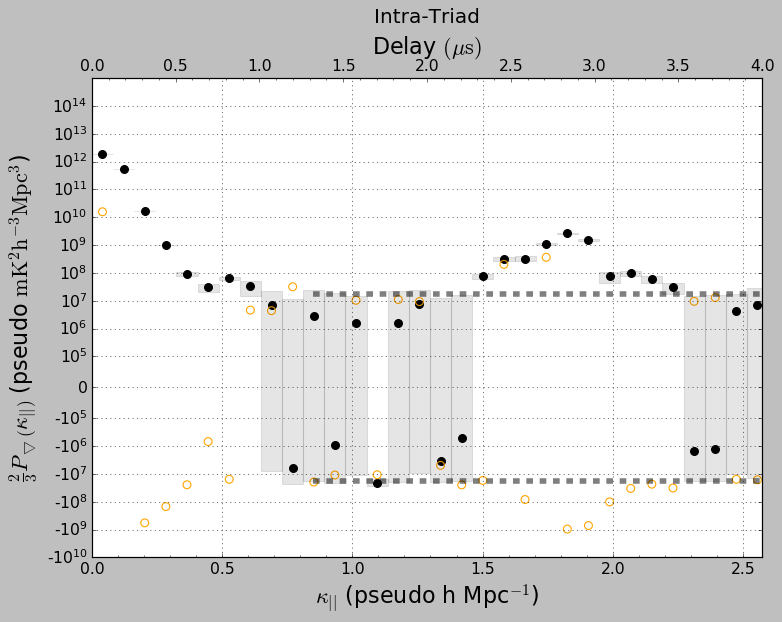

In [48]:
power1 = dspec.wavg(np.moveaxis(xps, 0, 2), offdiagonal=True)
error1 = np.mean(np.abs([dspec.wavg(np.moveaxis(err[i], 0, 2), offdiagonal=True) for i in range(err.shape[0])]), axis=0)
delay = dspec.delay(fs=fs, n=power1.shape[-1])

dspec.power_plot(
    delay,
    power1, 
    error1 / 4,
    linthresh=1e5,
    legend=False,
    onesided=True,
    title="Inter-Triad",
    path="/users/pkeller/plots/memo_plot_8.pdf"
)

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


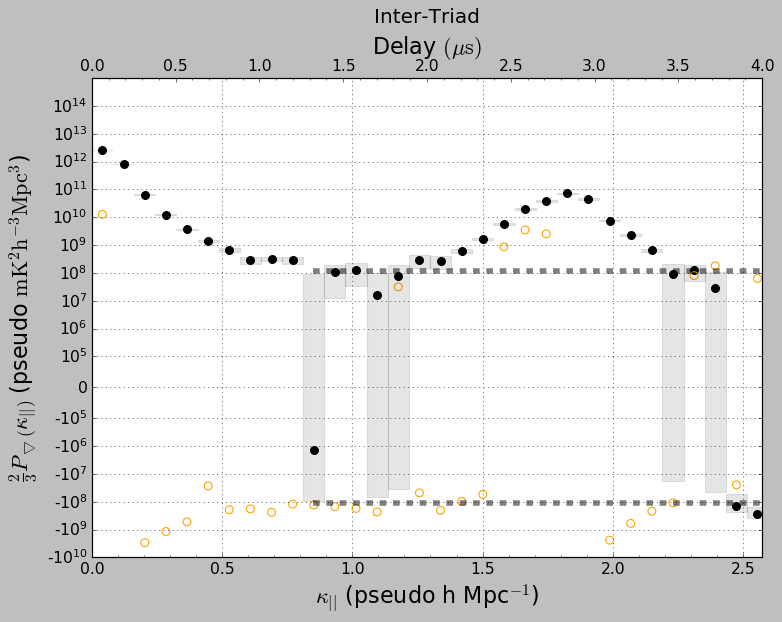

In [49]:
power2 = dspec.wavg(np.moveaxis(xps, 0, 2), offdiagonal=False, diagonal=True)
error2 = np.mean(np.abs([dspec.wavg(np.moveaxis(err[i], 0, 2), offdiagonal=False, diagonal=True) for i in range(err.shape[0])]), axis=0)
delay = dspec.delay(fs=fs, n=power2.shape[-1])

dspec.power_plot(
    delay,
    power2, 
    error2 / 4,
    linthresh=1e5,
    legend=False,
    onesided=True,
    title="Intra-Triad",
    path="/users/pkeller/plots/memo_plot_9.pdf"
)